In [1]:
# TensorFlow and tf.keras

# import tensorflow as tf

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import models
# import tensorflow.keras.utils
import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
import keras.utils



# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [2]:
data = np.load('/mnt/data/ml/Constituent4vecDataTest.npz')
#evnum = data['jetconstEvnum']
pt = data['jetconstPt']
eta = data['jetconstEta']
phi = data['jetconstPhi']
labels = data['labels']
tau21 = data['tau21']
chMult = data['chMult']

pt = pt.reshape(336227, 20)
eta = eta.reshape(336227, 20)
phi = phi.reshape(336227, 20)
labels = labels[::20]

fourvec = np.stack((pt,eta,phi), axis = -1)

#ensure same number of signal vs. background and even split of z events
qcd_vec = fourvec[np.where(labels[:,0] == 1)]
qcd_tau = tau21[np.where(labels[:,0] == 1)]
qcd_mult = chMult[np.where(labels[:,0] == 1)]

if len(qcd_vec) % 3 != 0:
    qcd_vec = qcd_vec[:len(qcd_vec)-(len(qcd_vec) % 3)]
    qcd_tau = qcd_tau[:len(qcd_vec)-(len(qcd_vec) % 3)]
    qcd_mult = qcd_mult[:len(qcd_vec)-(len(qcd_vec) % 3)]
    
z1_vec = fourvec[np.where(labels[:,1] == 1)]
z1_vec = z1_vec[:int(len(qcd_vec)/3)]
z1_tau = tau21[np.where(labels[:,1] == 1)]
z1_tau = z1_tau[:int(len(qcd_vec)/3)]
z1_mult = chMult[np.where(labels[:,1] == 1)]
z1_mult = z1_mult[:int(len(qcd_vec)/3)]

z2_vec = fourvec[np.where(labels[:,2] == 1)]
z2_vec = z2_vec[:int(len(qcd_vec)/3)]
z2_tau = tau21[np.where(labels[:,2] == 1)]
z2_tau = z2_tau[:int(len(qcd_vec)/3)]
z2_mult = chMult[np.where(labels[:,2] == 1)]
z2_mult = z1_mult[:int(len(qcd_vec)/3)]

z3_vec = fourvec[np.where(labels[:,3] == 1)]
z3_vec = z3_vec[:int(len(qcd_vec)/3)]
z3_tau = tau21[np.where(labels[:,3] == 1)]
z3_tau = z3_tau[:int(len(qcd_vec)/3)]
z3_mult = chMult[np.where(labels[:,3] == 1)]
z3_mult = z1_mult[:int(len(qcd_vec)/3)]

qcd_lab = np.zeros([len(qcd_vec), 2])
qcd_lab[:,0] = 1
z_lab = np.zeros([len(qcd_vec), 2])
z_lab[:,1] = 1

fourvec = np.vstack((qcd_vec, z1_vec, z2_vec, z3_vec))
taus = np.hstack((qcd_tau, z1_tau, z2_tau, z3_tau))
mults = np.hstack((qcd_mult, z1_mult, z2_mult, z3_mult))
labels = np.vstack((qcd_lab, z_lab))
print(len(labels), len(fourvec))

#split data into testing/training/validation
n_data = len(fourvec)
testvec = fourvec[::4]
testlabels = labels[::4]
testtaus = taus[::4]
testmults = mults[::4]

mask_vec = np.ones(fourvec.shape,dtype=bool)
mask_vec[::4] = 0
mask_vec[1::8] = 0
mask_lab = np.ones(labels.shape,dtype=bool)
mask_lab[::4] = 0
mask_lab[1::8] = 0
mask_tau = np.ones(taus.shape,dtype=bool)
mask_tau[::4] = 0
mask_tau[1::8] = 0
mask_mult = np.ones(mults.shape,dtype=bool)
mask_mult[::4] = 0
mask_mult[1::8] = 0

valvec = fourvec[1::8]
vallabels = labels[1::8]
valtaus = taus[1::8]
valmults = mults[1::8]

trainvec = fourvec[mask_vec].reshape((n_data-len(testvec)-len(valvec)),20,3)
trainlabels = labels[mask_lab].reshape((n_data-len(testvec)-len(valvec)), 2)
traintaus = taus[mask_tau].reshape((n_data-len(testvec)-len(valvec)), 1)
trainmults = mults[mask_mult].reshape((n_data-len(testvec)-len(valvec)), 1)

99240 99240


In [3]:
def build_model():
    
    input1 = layers.Input(shape = (20,3))

#    x = layers.Dense(64, activation='relu', name = 'relu1')(input1)
    x = layers.GRU(4*rnn_units, return_sequences = True, name = 'gru1')(input1)
    x = layers.GRU(4*rnn_units, return_sequences = True, name = 'gru2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GRU(rnn_units, return_sequences = True, name = 'gru3')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.GRU(rnn_units, return_sequences = True, name = 'gru4')(x)
    
    xf = layers.Flatten(name = "flatten")(x)
    
    input2 = layers.Input(shape=(1,))
    input3 = layers.Input(shape=(1,))
    
    x = layers.concatenate(inputs = [xf, input2, input3],axis=-1)
    
    x = layers.Dense(256, activation= 'relu', name = 'dense1')(x)
    

    output = layers.Dense(2, activation='softmax', name = 'output')(x)

    model = models.Model(inputs= [input1, input2, input3], outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

In [4]:
rnn_units = 32
batch = 20

RNN = build_model()

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
example_batch = trainvec[::300]
example_labels = trainlabels[::300]
example_taus = traintaus[::300]
example_mults = trainmults[::300]

example_result = RNN.predict(x = [example_batch, example_taus, example_mults])
results = RNN.evaluate(x = [example_batch, example_taus, example_mults], y = example_labels)

print(example_result)
print(results)

207/207 [==============================] - 0s 1ms/step
[[0.7925012  0.20749877]
 [0.91067755 0.08932246]
 [0.64388657 0.35611346]
 [0.5902211  0.40977895]
 [0.7195009  0.28049904]
 [0.8360393  0.16396064]
 [0.7844133  0.21558677]
 [0.7903412  0.20965882]
 [0.7005531  0.2994469 ]
 [0.87267333 0.12732667]
 [0.6523038  0.34769621]
 [0.6564596  0.34354037]
 [0.90606254 0.09393746]
 [0.8315503  0.16844968]
 [0.8492916  0.15070835]
 [0.83942807 0.16057192]
 [0.83784217 0.16215785]
 [0.7788067  0.22119327]
 [0.95438904 0.04561102]
 [0.6714123  0.3285877 ]
 [0.8332288  0.16677113]
 [0.6385751  0.36142495]
 [0.70137095 0.29862905]
 [0.8270197  0.17298035]
 [0.64820963 0.3517903 ]
 [0.7207848  0.2792152 ]
 [0.8167078  0.18329221]
 [0.7970283  0.20297171]
 [0.7042331  0.29576692]
 [0.6472148  0.35278526]
 [0.9295011  0.07049886]
 [0.94382787 0.0561721 ]
 [0.7840593  0.21594071]
 [0.68048984 0.3195101 ]
 [0.91880995 0.08119004]
 [0.6502972  0.34970272]
 [0.61356175 0.38643828]
 [0.87240547 0.12759

In [6]:
checkpoint_path = "model/CNN1D_v3.h5"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto')    
EPOCHS = 5
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = RNN.fit(
  [trainvec,traintaus, trainmults], trainlabels,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[early_stop, model_checkpoint])

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.79907, saving model to model/CNN1D_v3.h5

Epoch 00002: val_loss improved from 0.79907 to 0.78261, saving model to model/CNN1D_v3.h5

Epoch 00003: val_loss did not improve from 0.78261

Epoch 00004: val_loss did not improve from 0.78261

Epoch 00005: val_loss improved from 0.78261 to 0.72326, saving model to model/CNN1D_v3.h5


In [7]:
!ls model
best_model = keras.models.load_model('model/CNN1D_v3.h5')
best_model.summary()
results = best_model.evaluate([testvec, testtaus, testmults],  testlabels, verbose = 0)
print(results)

CNN1D_v3.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 3)        0                                            
__________________________________________________________________________________________________
gru1 (GRU)                      (None, 20, 128)      50688       input_1[0][0]                    
__________________________________________________________________________________________________
gru2 (GRU)                      (None, 20, 128)      98688       gru1[0][0]                       
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 20, 128)      512         gru2[0][0]                       
_________________________________________________________________________________________________

In [8]:
predict = best_model.predict([testvec , testtaus,testmults])

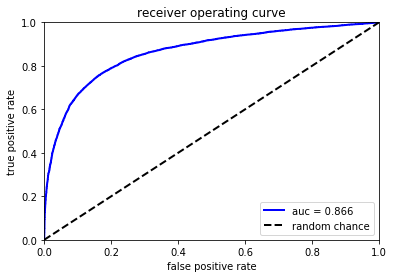

In [9]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels[:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

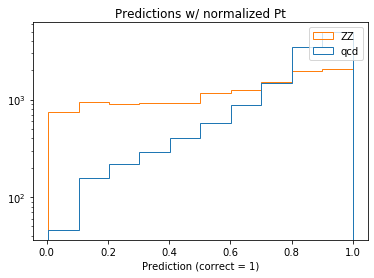

In [10]:
indqcd = np.argwhere(testlabels[:,0] == 1)
indz  = np.argwhere(testlabels[:,1] == 1) 
hist_, bin_edges_ = np.histogram(predict[indqcd])
plt.hist([predict[indqcd, 0].flatten(),predict[indz, 1].flatten()], histtype = 'step', label = ['qcd', 'ZZ'])
plt.legend()
plt.title('Predictions w/ normalized Pt')
plt.yscale('log')
plt.xlabel('Prediction (correct = 1)')
plt.show()

### LRP